In [2]:
import pandas as pd
import datetime
from statsforecast import StatsForecast as SF


Data Reading

In [3]:
e_data = pd.read_csv("data\household_power_consumption.txt", delimiter=";")

C:\Users\oyash\AppData\Local\Temp\ipykernel_2520\1816206322.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  e_data = pd.read_csv("data\household_power_consumption.txt", delimiter=";")


In [4]:

e_data.iloc[:,2:] = e_data.iloc[:,2:].apply(lambda x: pd.to_numeric(x, errors = "coerce"))
e_data["Date"] = e_data["Date"].map(str)
e_data["Time"] = e_data["Time"].map(str)
e_data["Date"] = pd.to_datetime(e_data["Date"])
e_data.fillna(method = "backfill", inplace = True)
# e_data["Time"] = pd.to_datetime(e_data["Time"])
e_data.dtypes
# e_data.head()
# 
# e_data.loc[5000,"Date"] - e_data.loc[0,"Date"]



C:\Users\oyash\AppData\Local\Temp\ipykernel_2520\1891919399.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  e_data.iloc[:,2:] = e_data.iloc[:,2:].apply(lambda x: pd.to_numeric(x, errors = "coerce"))
C:\Users\oyash\AppData\Local\Temp\ipykernel_2520\1891919399.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  e_data["Date"] = pd.to_datetime(e_data["Date"])


Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

Creating Daily Data for prediction

In [5]:
# e_data.loc[0:3,["Date","Time", "Voltage"]]
# e_data.iloc[:,2:]
# e_data[["Voltage"]].plot()
# e_data.groupby("Date").tail(1)

# CHECKS
# e_data.groupby("Date").count()

# To USE
ed_data = e_data.groupby("Date").sum().iloc[1:,].reset_index()

C:\Users\oyash\AppData\Local\Temp\ipykernel_2520\3120841562.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ed_data = e_data.groupby("Date").sum().iloc[1:,].reset_index()


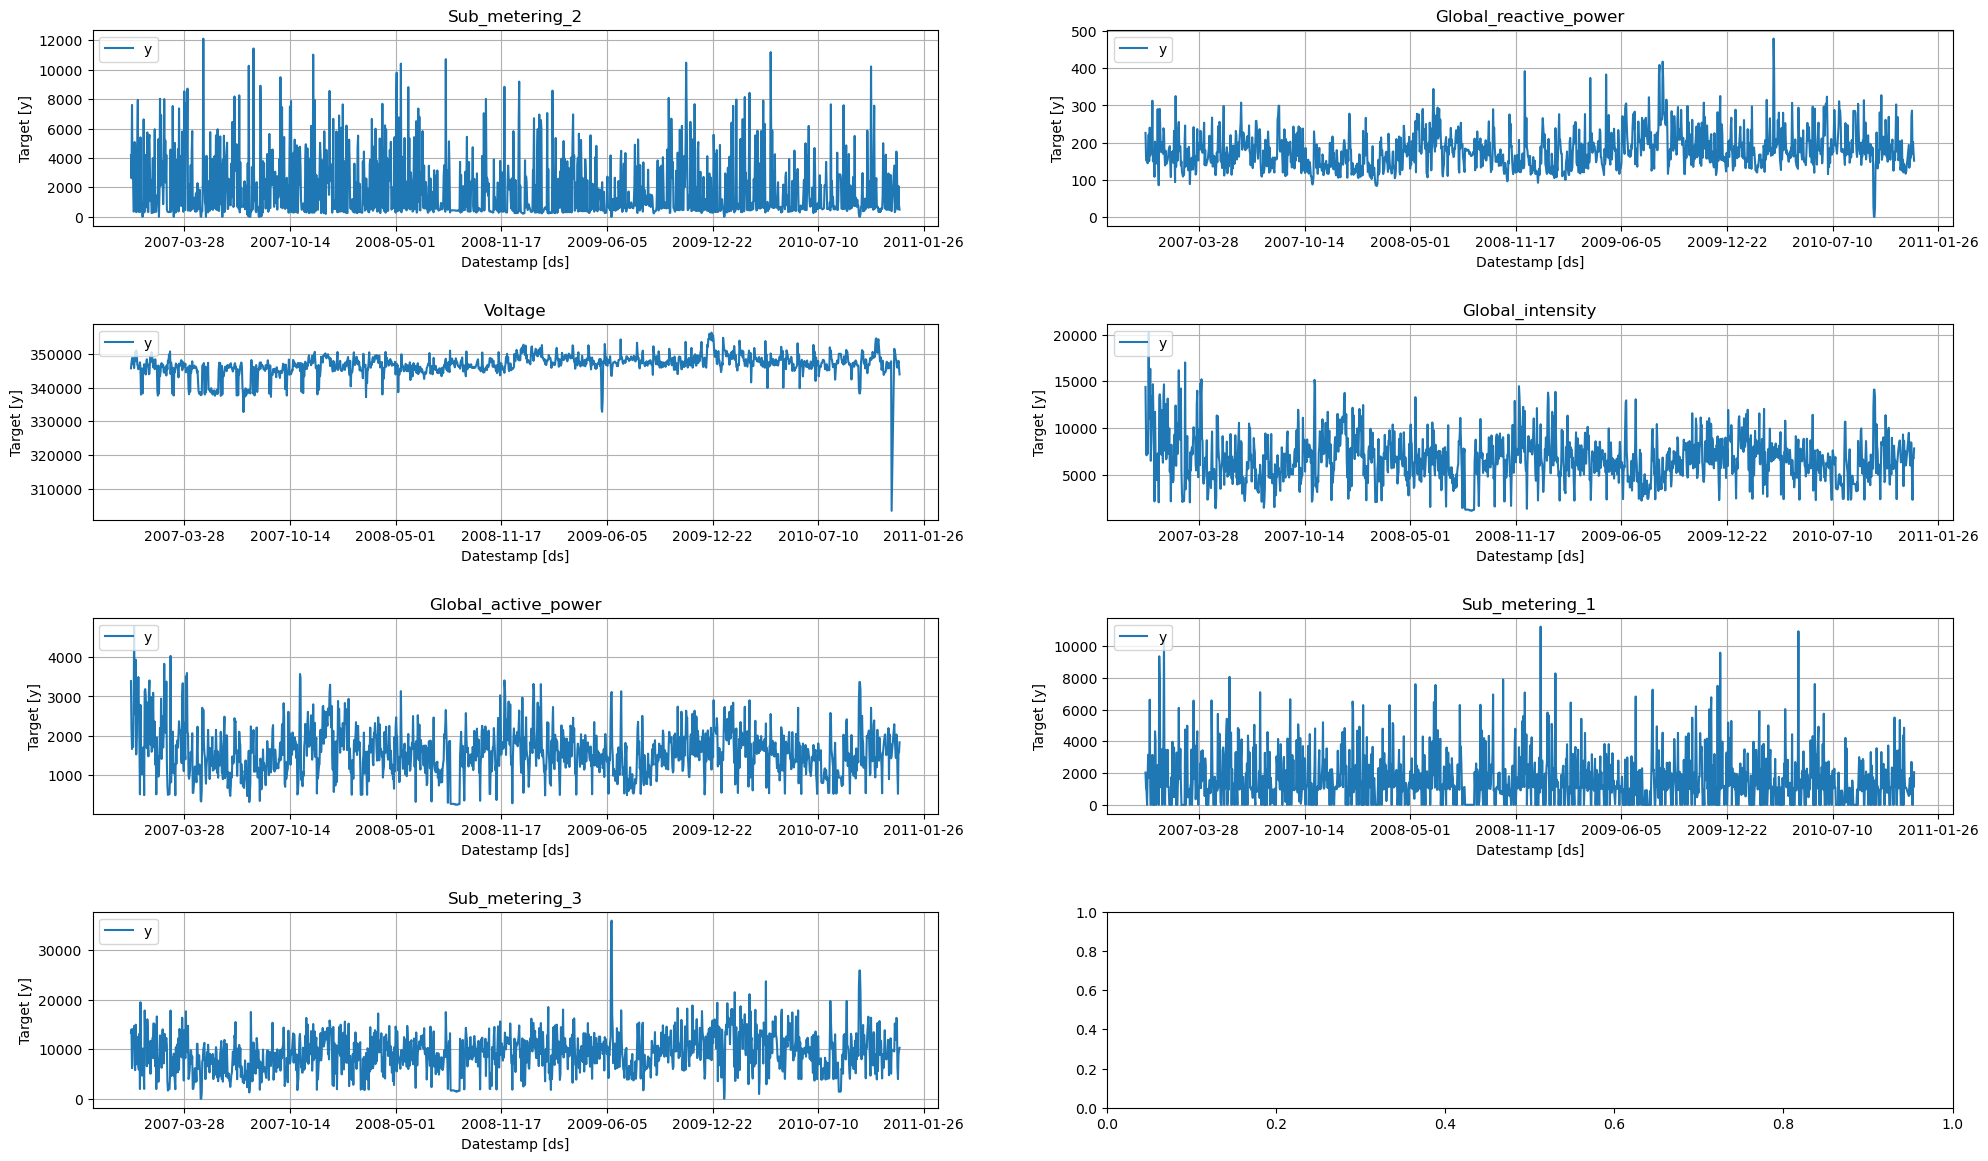

In [6]:
# SF.plot(ed_data.tail(100))
ed_data.shape
ed_data_long = ed_data.melt(id_vars=['Date'])
ed_data_long.rename(columns = {"Date":"ds", "variable":"unique_id", "value":"y"}, inplace= True)
ed_data_long.head()
SF.plot(ed_data_long, engine = "matplotlib")
# ed_data.head()

In [22]:
from statsforecast.models import (
    AutoARIMA,
    DynamicOptimizedTheta as DOT
)


In [23]:
models = [AutoARIMA(season_length = 30),
DOT(season_length=30)]

In [24]:
sf = SF(df = ed_data_long, models = models, freq = "D", n_jobs = -1)

In [28]:
forecast_df = sf.forecast(h = 30, level = [90])
forecast_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,
Global_active_power,2010-12-12,1685.594238,698.846558,2672.341797,1520.317383,721.500427,2527.879883
Global_active_power,2010-12-13,1513.104248,168.832520,2857.375977,1510.028931,539.823364,2274.536133
Global_active_power,2010-12-14,1479.164429,-108.411102,3066.739990,1482.213257,309.672119,2410.196533
Global_active_power,2010-12-15,1390.629639,-378.821472,3160.080566,1512.082031,491.048462,2358.921387
Global_active_power,2010-12-16,1309.020386,-602.407166,3220.447998,1548.236938,429.197296,2693.587891


In [35]:
sf.plot(ed_data_long,forecast_df)

In [30]:
crossvalidation_df = sf.cross_validation(
    df = ed_data_long,
    h = 30,
    step_size = 30,
    n_windows = 3
)

In [33]:
crossvalidation_df.head()

,ds,cutoff,y,AutoARIMA,DynamicOptimizedTheta
unique_id,,,,,
Global_active_power,2010-09-13,2010-09-12,1534.682007,1444.816895,1557.868164
Global_active_power,2010-09-14,2010-09-12,1083.478027,1332.948608,1586.010498
Global_active_power,2010-09-15,2010-09-12,535.064026,1187.036255,1533.728760
Global_active_power,2010-09-16,2010-09-12,1238.713989,1161.467163,1531.934814
Global_active_power,2010-09-17,2010-09-12,1611.780029,1098.138062,1560.599487


In [ ]:
from datasetsforecast.losses import mse, mae, rmse

